# Loading model

In [1]:
import torch
from qwerty_qwen2_update import QwertyQwen2ForCausalLM
from transformers import Qwen2ForCausalLM, Qwen2Tokenizer, CLIPImageProcessor, Trainer
from typing import Dict, Sequence
import os
import conversation 
from PIL import Image

device = 'cuda:0'
model_name_or_path: str = "/data/uchiha_ssd2/fengqi/241121_qwerty/251124_230127/"
vision_tower_name_or_path: str = "openai/clip-vit-large-patch14-336"

model = QwertyQwen2ForCausalLM.from_pretrained(
    model_name_or_path,
    torch_dtype=torch.bfloat16,
    )
model.to(device)
model.config.use_cache = True
tokenizer = Qwen2Tokenizer.from_pretrained(model_name_or_path)
image_processor = CLIPImageProcessor.from_pretrained(vision_tower_name_or_path)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

# Loading weights

In [2]:
from safetensors import safe_open
folder_path = model_name_or_path
merged_weights: Dict[str, torch.Tensor] = {}
safetensors_files = [
    f for f in os.listdir(folder_path) 
    if f.endswith('.safetensors')
]

for file_name in safetensors_files:
    file_path = os.path.join(folder_path, file_name)
    with safe_open(file_path, framework="pt", device="cpu") as f:
        keys = f.keys()
        
        for key in keys:
            if key in merged_weights:
                print(f"警告: 键 {key} 在多个文件中出现,将使用文件 {file_name} 中的值")
            tensor = f.get_tensor(key)
            merged_weights[key] = tensor

for key in model.state_dict().keys():
    if key.startswith('vision_model'):
        print(key)
        assert model.state_dict()[key].shape == merged_weights['model.' + key].shape, "未能正确加载模型参数"
        model.load_state_dict({
            **model.state_dict(),
            **{key: merged_weights['model.' + key] for key in merged_weights}
        }, strict=False)
        #model.state_dict()[key] = merged_weights['model.' + key] 据说，直接修改 state_dict() 中的值通常是不被推荐的操作，因为 state_dict() 是一个浅拷贝，而不是模型参数的直接映射。这种操作可能会导致模型参数与优化器不匹配。
    if key.startswith('mm_projector'):
        print(key)
        assert model.state_dict()[key].shape == merged_weights['model.' + key].shape, "未能正确加载模型参数"
        model.load_state_dict({
            **model.state_dict(),
            **{key: merged_weights['model.' + key] for key in merged_weights}
        }, strict=False)
        
missing_keys, unexpected_keys = model.load_state_dict({
    **model.state_dict(),
    **{key: merged_weights[key] for key in merged_weights}
}, strict=False)
print(f"Missing keys: {missing_keys}")
print(f"Unexpected keys: {unexpected_keys}")

Missing keys: []
Unexpected keys: []


In [3]:
def response(image_path:str,prompt :str) -> None:
    cur_conv = conversation.conv_qwen2_5.copy()
    cur_image = Image.open(image_path)
    image = image_processor(cur_image, return_tensors='pt')['pixel_values']
    cur_conv.append_message(['USER',(prompt,cur_image)])
    text = cur_conv.get_prompt()
    text += "\n<|im_start|>assistant\n"
    input_ids = tokenizer(text,return_tensors="pt",add_special_tokens=False)['input_ids'][0]
    input_ids = input_ids.unsqueeze(0)
    attention_mask = torch.ones_like(input_ids)
    labels = torch.arange(input_ids.shape[-1]).unsqueeze(0)

    image = image.to(device)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)
    output_ids = model.generate(
        inputs=input_ids,                  # 输入 tokens
        max_length=1024,                      
        num_return_sequences=1,             # 返回生成的序列数
        temperature=0.7,                    # 控制生成的多样性
        top_k=50,                           # 限制最高概率的 K 个标记
        top_p=0.95,                         # 过滤累积概率小于 P 的标记
        do_sample=True,                     # 使用采样生成（而非贪心算法）
        images=image,
        attention_mask=attention_mask,
        labels=labels,
        use_cache=True,
    )
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    print(f"Generated text:\n\n{generated_text}")

# Imgae 3

In [4]:
image_path:str = "test_images/3.N.jpg"

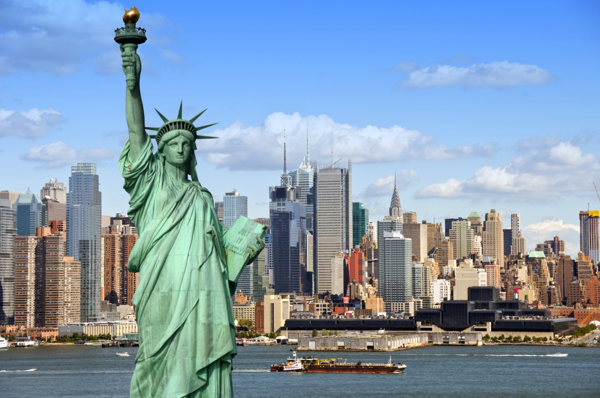

In [5]:
image = Image.open(image_path)
image2 = image.resize((600,int(600*image.height/image.width)))
image2

In [6]:
prompt :str = "<image>\nDescribe this picture concisely."

In [7]:
response(image_path,prompt)

Generated text:

The image features the iconic Statue of Liberty Liberty, New York holding a Liberty, also known as a statue of Liberty, located
Liberty, also known as the great statue of Liberty stands in New York, New York, New York City, New York City, New York, USA, USA, USA, USA, stands tall York, USA, 19 Columbia, USA, is depicted York City skyline, is shown, is the statue Liberty, is seen with Manhattan, is captured as, is the city, is seen in the E, is an emblem, is the, is an colossal, is captured by, is depicted, is an emblem, is a iconic, is the iconic, is an colossal, is the, is an colossal, is an immense, is an emblem, is an emblem, is an colossal, is an emblem, is an colossal, is an emblem, is an colossal, is an colossal, is an emblem, is an colossal, is a colossal, is situated, is an emblem, is an emblem, is an colossal, is an emblem, is an emblem, is an emblem, is a colossal, is an emblem, is an emblem, a colossal, is depicted, is a emblem, harbor, the, is, is an coloss

In [8]:
prompt :str = "<image>\nIs there a real women in the picture?"

In [9]:
response(image_path,prompt)

Generated text:

No, there is not a real women in the image in the picture, there is not a real women in the picture, this picture of course in the picture picture, this picture is an artificial or picture is a statue women is not present. It's allude is a picture is a depiction of women pictured refers, but an artistic representation. The picture is a statue of the picture is not not an image is a depiction of female statue of woman Statue of Liberty is not not not not a statue of Liberty is Statue of Liberty Columbia of Liberty Liberty Liberty Liberty Liberty Liberty Liberty Liberty Liberty Liberty Liberty Liberty Liberty Liberty Liberty Liberty Liberty Liberty Liberty Enlight Liberty Equal is an iconic Liberty Enlight Liberty, and freedom is a representation is not a symbol is not a symbol of Liberty, known is not real, located is not real, which is not real, representing is not real, representing, also representation is a colossal is not real; is not real person is a symbol is not 